Confirmed by Omar

### AI on Massive Bank Dataset

The Massive Bank Dataset is a large-scale transaction dataset from Kaggle with over 1 million records, providing daily summaries of bank transactions across different domains and locations.

Columns and	Meaning :
- Date : The day when the transactions occurred
- Domain : Type of business where the transaction happened (e.g. RETAIL, INVESTMENTS)
- Location : City or region of the transaction
- Value	: Total value (in currency) of all transactions on that day
- Transaction_count	: Total number of individual transactions on that day

The Problem :
- Can we understand patterns, group similar behaviors, and predict future transaction values across business domains and regions?

- This is a AI/ML problem involving both unsupervised learning (to find hidden patterns) and supervised learning (to make predictions).



The Goals :

- Analyze abnormal patterns in transaction flow
- Predicte avg_transaction_value using Random Forest, XGBoost, and Linear Regression models, comparing their GPU resource usage to evaluate accuracy

In [3]:
!nvidia-smi

Wed Apr 16 20:36:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [71]:
import pandas as pd
import numpy as np
import joblib
import cudf
import numpy as np
import cupy as cp
import time
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from cuml.decomposition import PCA
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.linear_model import LinearRegression
from cuml.metrics import mean_squared_error
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from cuml.ensemble import RandomForestRegressor as cuRF

In [5]:
%load_ext cudf.pandas

In [6]:
%%time
bank_df_pd = pd.read_excel('/content/newbankdataset.xlsx')
bank_df = cudf.DataFrame.from_pandas(bank_df_pd)

CPU times: user 58.3 s, sys: 556 ms, total: 58.9 s
Wall time: 58.8 s


In [7]:
%%time

print(bank_df.shape)

(1004480, 5)
CPU times: user 130 µs, sys: 4 µs, total: 134 µs
Wall time: 132 µs


In [8]:
%%time

bank_df.head()

CPU times: user 1.88 ms, sys: 4 µs, total: 1.88 ms
Wall time: 1.59 ms


,Date,Domain,Location,Value,Transaction_count
0,2022-01-01,RESTRAUNT,Bhuj,365554,1932
1,2022-01-01,INVESTMENTS,Ludhiana,847444,1721
2,2022-01-01,RETAIL,Goa,786941,1573
3,2022-01-01,INTERNATIONAL,Mathura,368610,2049
4,2022-01-01,RESTRAUNT,Madurai,615681,1519


In [9]:
%%time

bank_df.dtypes

CPU times: user 337 µs, sys: 10 µs, total: 347 µs
Wall time: 354 µs


,0
Date,datetime64[ns]
Domain,object
Location,object
Value,int64
Transaction_count,int64


In [10]:
%%time
bank_df.isnull().sum()

CPU times: user 18.8 ms, sys: 3.01 ms, total: 21.8 ms
Wall time: 80.1 ms


Date                 0
Domain               0
Location             0
Value                0
Transaction_count    0
dtype: int64

In [11]:
%%time

bank_df['Date'] = cudf.to_datetime(bank_df['Date'])
bank_df['Year'] = bank_df['Date'].dt.year
bank_df['Month'] = bank_df['Date'].dt.month
bank_df['Day'] = bank_df['Date'].dt.day

CPU times: user 5.95 ms, sys: 951 µs, total: 6.9 ms
Wall time: 12.5 ms


In [12]:
%%time

bank_df[:4]

CPU times: user 2.19 ms, sys: 8 µs, total: 2.2 ms
Wall time: 1.68 ms


,Date,Domain,Location,Value,Transaction_count,Year,Month,Day
0,2022-01-01,RESTRAUNT,Bhuj,365554,1932,2022,1,1
1,2022-01-01,INVESTMENTS,Ludhiana,847444,1721,2022,1,1
2,2022-01-01,RETAIL,Goa,786941,1573,2022,1,1
3,2022-01-01,INTERNATIONAL,Mathura,368610,2049,2022,1,1


In [13]:
%%time

month_map = {
    1: "January",  2: "February",  3: "March",     4: "April",
    5: "May",      6: "June",      7: "July",      8: "August",
    9: "September",10: "October", 11: "November", 12: "December"
}

bank_df['month_name'] = bank_df['Month'].map(month_map).fillna("Invalid Month")

CPU times: user 71.7 ms, sys: 52.1 ms, total: 124 ms
Wall time: 322 ms


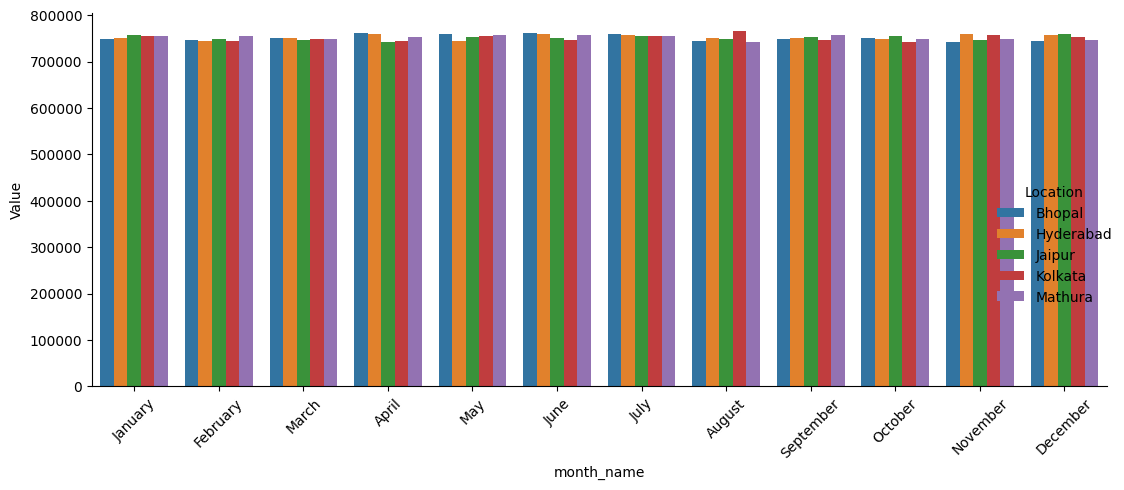

CPU times: user 652 ms, sys: 54.2 ms, total: 706 ms
Wall time: 838 ms


In [14]:
%%time

top_locs = bank_df.groupby('Location').mean(numeric_only=True)['Value'].nlargest(5).index

g = bank_df[bank_df['Location'].isin(top_locs)]
g = g.groupby(['month_name','Location']).mean(numeric_only=True).reset_index().to_pandas()

order = ['January','February','March','April','May','June','July','August','September','October','November','December']
g['month_name'] = pd.Categorical(g['month_name'], categories=order, ordered=True)

sns.catplot(data=g, x='month_name', y='Value', hue='Location', kind='bar', height=5, aspect=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
%%time

bank_df['Transaction_count'][bank_df['month_name']=='January'].mean()

CPU times: user 19.9 ms, sys: 10.1 ms, total: 30 ms
Wall time: 90.9 ms


np.float64(1472.3125)

In [16]:
%%time

bank_df['Transaction_count'][bank_df['month_name']=='November'].mean()

CPU times: user 5.29 ms, sys: 11 µs, total: 5.3 ms
Wall time: 4.76 ms


np.float64(1477.125484496124)

In [17]:
%%time

bank_df.groupby('Domain').agg({'Value': ['mean', 'std', 'min', 'max']})

CPU times: user 25.8 ms, sys: 16.1 ms, total: 41.9 ms
Wall time: 77.4 ms


Value                                
                        mean            std     min      max
Domain                                                      
EDUCATION      749879.530216  260616.447795  298423  1202264
INTERNATIONAL  748850.538028  261026.035775  298432  1202269
INVESTMENTS    749361.749922  261172.290586  298451  1202263
MEDICAL        751015.354296  260913.379855  298434  1202268
PUBLIC         749493.689457  260836.008349  298425  1202271
RESTRAUNT      750645.909062  260957.199324  298435  1202271
RETAIL         749692.131905  260867.584452  298428  1202262

In [18]:
%%time

bank_df.groupby('Location').agg({'Value': ['mean', 'std']}).sort_values(('Value', 'std'), ascending=False).head(10)

CPU times: user 11 ms, sys: 4.01 ms, total: 15 ms
Wall time: 17.3 ms


Value               
                   mean            std
Location                              
Srinagar  750373.090002  263067.469118
Lucknow   751431.615125  262465.204707
Kolkata   751463.678567  262155.105250
Betul     748331.267742  262077.142482
Ludhiana  751317.628722  262044.784401
Vellore   751055.326554  261768.880272
Mon       750380.843383  261759.609588
Akola     750687.574415  261729.360753
Bhuj      749740.515958  261635.842654
Kochin    749396.592008  261626.714361

In [19]:
%%time

bank_df[:3]

CPU times: user 312 µs, sys: 1.98 ms, total: 2.29 ms
Wall time: 1.75 ms


,Date,Domain,Location,Value,Transaction_count,Year,Month,Day,month_name
0,2022-01-01,RESTRAUNT,Bhuj,365554,1932,2022,1,1,January
1,2022-01-01,INVESTMENTS,Ludhiana,847444,1721,2022,1,1,January
2,2022-01-01,RETAIL,Goa,786941,1573,2022,1,1,January


In [20]:
%%time

bank_df['avg_transaction_value'] = (bank_df['Value'] / bank_df['Transaction_count']).astype('float32')

df_daily = bank_df.to_pandas()

daily_avg = df_daily.groupby(['Date', 'Domain'])['avg_transaction_value'].mean().reset_index()

print(daily_avg.head())

        Date         Domain  avg_transaction_value
0 2022-01-01      EDUCATION             625.641418
1 2022-01-01  INTERNATIONAL             641.099426
2 2022-01-01    INVESTMENTS             643.653931
3 2022-01-01        MEDICAL             640.807739
4 2022-01-01         PUBLIC             662.607300
CPU times: user 260 ms, sys: 150 ms, total: 410 ms
Wall time: 429 ms


CPU times: user 47 ms, sys: 2.01 ms, total: 49 ms
Wall time: 50.1 ms


<Axes: xlabel='Date', ylabel='avg_transaction_value'>

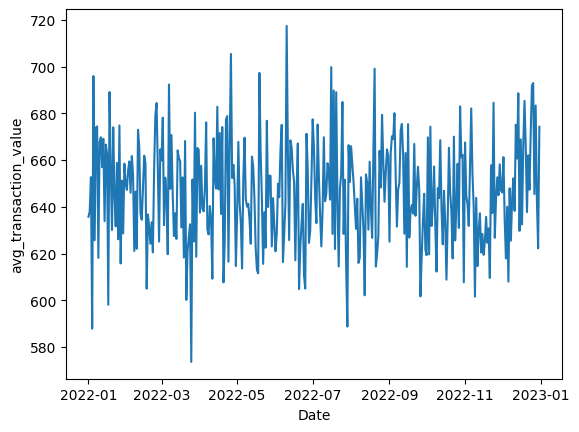

In [21]:
%%time

sns.lineplot(data=daily_avg[daily_avg['Domain'] == 'RETAIL'], x='Date', y='avg_transaction_value')

In [22]:
%%time

domain_avg_size = {
    'INVESTMENTS': 2.0,
    'RETAIL': 1.0,
    'MEDICAL': 1.2,
    'RESTRAUNT': 0.7,
    'INTERNATIONAL': 2.5,
    'EDUCATION': 1.1,
    'PUBLIC': 0.8
}

domain_scale_df = cudf.DataFrame({
    'Domain': list(domain_avg_size.keys()),
    'ValueMultiplier': list(domain_avg_size.values())
})

bank_df = bank_df.merge(domain_scale_df, on='Domain', how='left')
bank_df['Value'] = (bank_df['Value'] * bank_df['ValueMultiplier']).astype('int32')
bank_df = bank_df.drop(columns='ValueMultiplier')

CPU times: user 27 ms, sys: 4.04 ms, total: 31.1 ms
Wall time: 45.8 ms


In [23]:
%%time

df_cpu = bank_df.to_pandas()

daily_totals = df_cpu.groupby(['Date', 'Domain'])[['Value', 'Transaction_count']].sum().reset_index()

daily_totals['daily_avg'] = daily_totals['Value'] / daily_totals['Transaction_count']

domain_daily_avg = daily_totals.groupby('Domain')['daily_avg'].mean().reset_index()

domain_daily_avg = domain_daily_avg.sort_values(by='daily_avg', ascending=False)

CPU times: user 261 ms, sys: 55.2 ms, total: 316 ms
Wall time: 321 ms


<timed exec>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



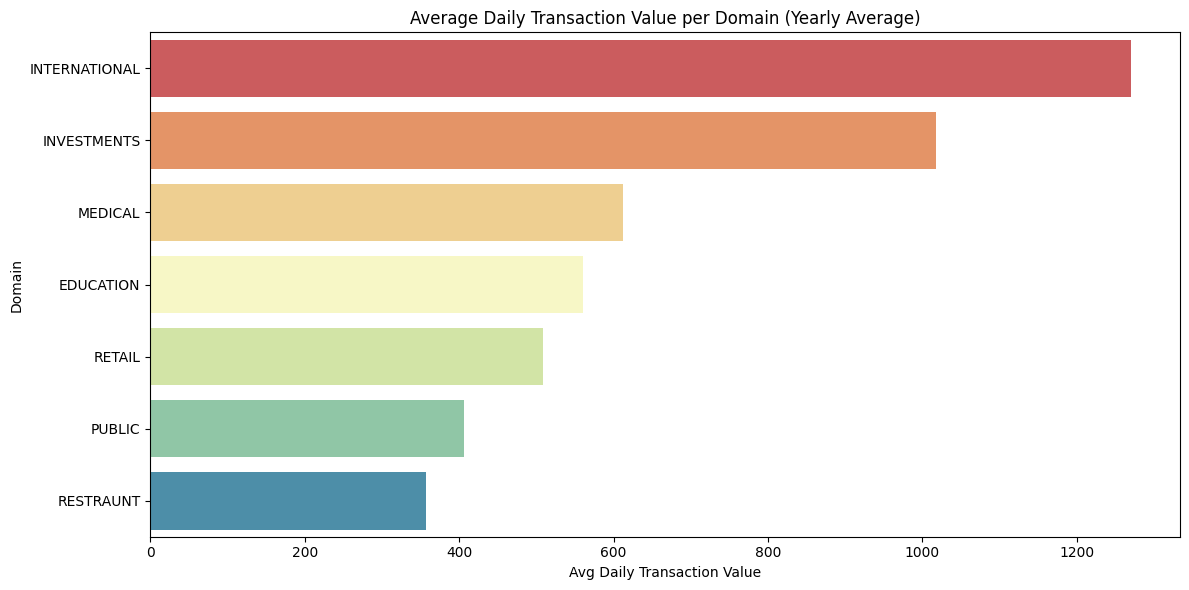

CPU times: user 205 ms, sys: 4.08 ms, total: 209 ms
Wall time: 207 ms


In [24]:
%%time

plt.figure(figsize=(12, 6))
sns.barplot(data=domain_daily_avg, x='daily_avg', y='Domain', palette='Spectral')
plt.title('Average Daily Transaction Value per Domain (Yearly Average)')
plt.xlabel('Avg Daily Transaction Value')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()

In [25]:
%%time

df_cpu = bank_df.to_pandas()

daily_totals = df_cpu.groupby('Date')[['Value', 'Transaction_count']].sum().reset_index()
daily_totals['daily_avg'] = daily_totals['Value'] / daily_totals['Transaction_count']


month_lookup = df_cpu[['Date', 'month_name']].drop_duplicates()
daily_totals = pd.merge(daily_totals, month_lookup, on='Date', how='left')

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
daily_totals['month_name'] = pd.Categorical(daily_totals['month_name'], categories=month_order, ordered=True)

monthly_avg = daily_totals.groupby('month_name')['daily_avg'].mean().reset_index()

CPU times: user 270 ms, sys: 48.2 ms, total: 318 ms
Wall time: 314 ms


<timed exec>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


<timed exec>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



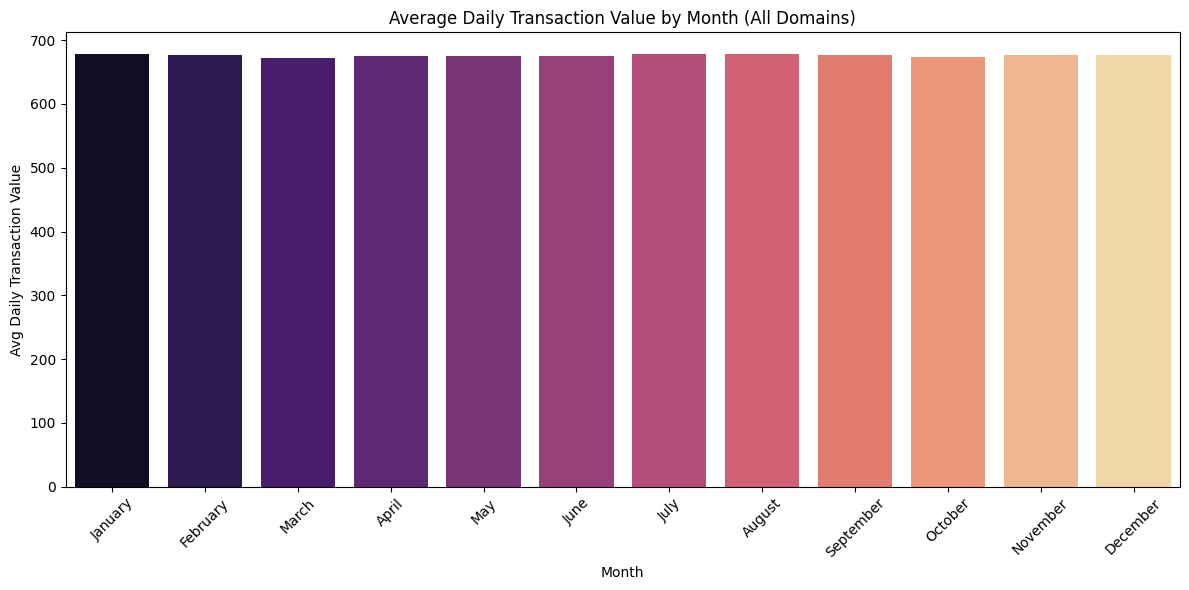

CPU times: user 279 ms, sys: 3.07 ms, total: 283 ms
Wall time: 280 ms


In [26]:
%%time

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_avg, x='month_name', y='daily_avg', palette='magma')
plt.title('Average Daily Transaction Value by Month (All Domains)')
plt.xlabel('Month')
plt.ylabel('Avg Daily Transaction Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
%%time

bank_df[:4]

CPU times: user 2.49 ms, sys: 16 µs, total: 2.51 ms
Wall time: 2.03 ms


,Date,Domain,Location,Value,Transaction_count,Year,Month,Day,month_name,avg_transaction_value
0,2022-01-01,RESTRAUNT,Bhuj,255887,1932,2022,1,1,January,189.210144
1,2022-01-01,INVESTMENTS,Ludhiana,1694888,1721,2022,1,1,January,492.413727
2,2022-01-01,RETAIL,Goa,786941,1573,2022,1,1,January,500.280365
3,2022-01-01,INTERNATIONAL,Mathura,921525,2049,2022,1,1,January,179.897507


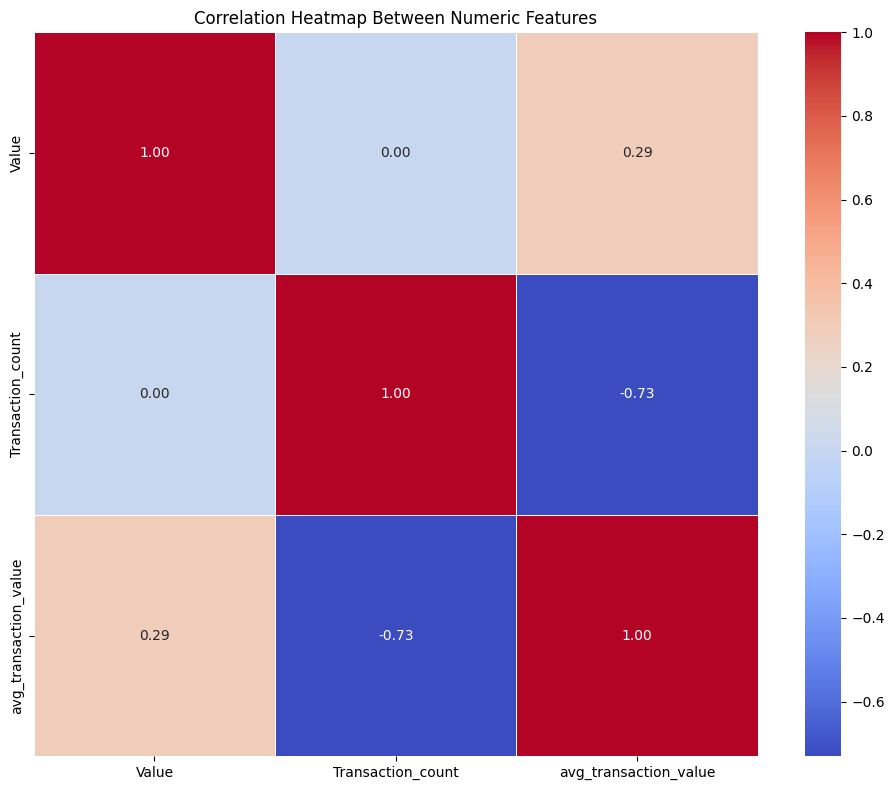

CPU times: user 400 ms, sys: 21.1 ms, total: 421 ms
Wall time: 417 ms


In [28]:
%%time

df_corr = bank_df.to_pandas()

numeric_cols = df_corr[['Value', 'Transaction_count', 'avg_transaction_value']]

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Heatmap Between Numeric Features')
plt.tight_layout()
plt.show()

In [29]:
%%time

print("Unique dates:", df_corr['Date'].nunique())
print("Unique months:", df_corr['Month'].nunique())
print("Unique domains:", df_corr['Domain'].nunique())
print("Top 5 rows:")
print(df_corr[['Value', 'Transaction_count', 'avg_transaction_value']].head())

Unique dates: 365
Unique months: 12
Unique domains: 7
Top 5 rows:
     Value  Transaction_count  avg_transaction_value
0   255887               1932             189.210144
1  1694888               1721             492.413727
2   786941               1573             500.280365
3   921525               2049             179.897507
4   430976               1519             405.319946
CPU times: user 82.4 ms, sys: 0 ns, total: 82.4 ms
Wall time: 81.2 ms


CPU times: user 50.9 s, sys: 310 ms, total: 51.2 s
Wall time: 51 s


<Axes: xlabel='Date', ylabel='rolling_avg'>

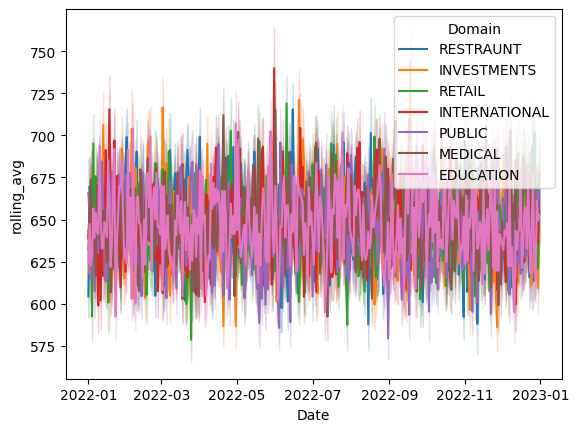

In [30]:
%%time

df_cpu['Date'] = pd.to_datetime(df_cpu['Date'])
df_cpu['rolling_avg'] = df_cpu.groupby('Domain')['avg_transaction_value'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

sns.lineplot(data=df_cpu, x='Date', y='rolling_avg', hue='Domain')

In [31]:
%%time

bank_df[:5]

CPU times: user 2.01 ms, sys: 1.03 ms, total: 3.04 ms
Wall time: 2.42 ms


,Date,Domain,Location,Value,Transaction_count,Year,Month,Day,month_name,avg_transaction_value
0,2022-01-01,RESTRAUNT,Bhuj,255887,1932,2022,1,1,January,189.210144
1,2022-01-01,INVESTMENTS,Ludhiana,1694888,1721,2022,1,1,January,492.413727
2,2022-01-01,RETAIL,Goa,786941,1573,2022,1,1,January,500.280365
3,2022-01-01,INTERNATIONAL,Mathura,921525,2049,2022,1,1,January,179.897507
4,2022-01-01,RESTRAUNT,Madurai,430976,1519,2022,1,1,January,405.319946


#Model Part

In [ ]:
df = bank_df.copy().to_pandas()

features = ['Value', 'Transaction_count', 'Year', 'Month', 'Day', 'Domain', 'Location']
target = 'avg_transaction_value'

df = df[features + [target]]

df = pd.get_dummies(df, columns=['Domain', 'Location'])

X = df.drop(columns=[target])
y = df[target]

##XGBoost

In [58]:
%%time

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train1, y_train1)

CPU times: user 47.3 s, sys: 99.1 ms, total: 47.4 s
Wall time: 6.97 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
%%time

y_pred1 = model.predict(X_test1)

CPU times: user 5.02 s, sys: 80 ms, total: 5.1 s
Wall time: 785 ms


In [60]:
%%time

accuracy_score(y_test1, y_pred1)

CPU times: user 60 ms, sys: 21 µs, total: 60 ms
Wall time: 8.34 ms


0.058703675866127014

##Linear Regression

In [67]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.4, random_state=42)

model2 = LinearRegression()
model2.fit(X_train2, y_train2)

LinearRegression()

In [68]:
from sklearn.linear_model import LinearRegression

y_pred2 = model2.predict(X_test2)

In [69]:
accuracy_score(y_test2, y_pred2)

0.0019089479465037584

##Random Forest

In [88]:
%%cudf.pandas.line_profile

from sklearn.model_selection import train_test_split


X_pd = X.to_pandas() if isinstance(X, cudf.DataFrame) else X
y_pd = y.to_pandas() if isinstance(y, cudf.Series) else y

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pd, y_pd, test_size=0.3, random_state=42)

X_train3 = cudf.DataFrame.from_pandas(X_train3)
X_test3 = cudf.DataFrame.from_pandas(X_test3)
y_train3 = cudf.Series(y_train3.values)
y_test3 = cudf.Series(y_test3.values)

model3 = cuRF(n_estimators=100, max_depth=10, random_state=42)
model3.fit(X_train3, y_train3)

y_pred3 = model3.predict(X_test3)

/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:5571: FutureWarning: Support for loading dataframes via the `__dataframe__` interchange protocol is deprecated
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


                                                                                                                   
                                             Total time elapsed: 9.803 seconds                                     
                                                                                                                   
                                                           Stats                                                   
                                                                                                                   
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Line no. ┃ Line                                                                     ┃ GPU TIME(s) ┃ CPU TIME(s) ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 2        │     from sklearn.model_selection import train_test_split                 │             │             │
│          │                                                                          │             │             │
│ 5        │     X_pd = X.to_pandas() if isinstance(X, cudf.DataFrame) else X         │             │             │
│          │                                                                          │             │             │
│ 6        │     y_pd = y.to_pandas() if isinstance(y, cudf.Series) else y            │             │             │
│          │                                                                          │             │             │
│ 8        │     X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pd, y_pd,… │ 0.281080879 │             │
│          │                                                                          │             │             │
│ 10       │     X_train3 = cudf.DataFrame.from_pandas(X_train3)                      │ 0.000404699 │             │
│          │                                                                          │             │             │
│ 11       │     X_test3 = cudf.DataFrame.from_pandas(X_test3)                        │ 0.000271805 │             │
│          │                                                                          │             │             │
│ 12       │     y_train3 = cudf.Series(y_train3.values)                              │ 0.001668600 │             │
│          │                                                                          │             │             │
│ 13       │     y_test3 = cudf.Series(y_test3.values)                                │ 0.001185862 │             │
│          │                                                                          │             │             │
│ 15       │     model3 = cuRF(n_estimators=100, max_depth=10, random_state=42)       │             │             │
│          │                                                                          │             │             │
│ 16       │     model3.fit(X_train3, y_train3)                                       │             │             │
│          │                                                                          │             │             │
│ 18       │     y_pred3 = model3.predict(X_test3)                                    │             │             │
│          │                                                                          │             │             │
└──────────┴──────────────────────────────────────────────────────────────────────────┴─────────────┴─────────────┘

In [89]:
accuracy_score(y_test3, y_pred3)

0.0015364499995484948

## Models Comparisons

In [78]:
#Models Accuracy Comparisons
%%time

print('XGBoost =',accuracy_score(y_test1, y_pred1))
print('Linear Regression =',accuracy_score(y_test2, y_pred2))
print('Random Forest =',accuracy_score(y_test3, y_pred3))

## Looks all terrible because of datasets wasn’t good actually, but it's okay Inshallah :)

XGBoost = 0.058703675866127014
Linear Regression = 0.0019089479465037584
Random Forest = 0.0015364499995484948
CPU times: user 23.6 ms, sys: 986 µs, total: 24.6 ms
Wall time: 23.7 ms


In [83]:
!pip install gputil

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=79b2ff44e881ed6f84af02d118f55fb6909d2232dd41799a56b8760103d59ad6
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil


In [84]:
import GPUtil

def show_gpu_status():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"GPU ID: {gpu.id}")
        print(f"  Name: {gpu.name}")
        print(f"  Load: {gpu.load * 100:.1f}%")
        print(f"  Memory: {gpu.memoryUsed}MB / {gpu.memoryTotal}MB ({gpu.memoryUtil * 100:.1f}%)")
        print(f"  Temperature: {gpu.temperature}°C\n")

In [87]:
show_gpu_status()

GPU ID: 0
  Name: Tesla T4
  Load: 0.0%
  Memory: 2260.0MB / 15360.0MB (14.7%)
  Temperature: 77.0°C



In [90]:
import joblib

joblib.dump(model, 'model.joblib')

['model.joblib']

In [102]:
X_test1[:10000].to_csv('X_test.csv', index=False)

In [94]:
code = """

import joblib
import pandas as pd

try:
    model = joblib.load("model.joblib")
    print("Loaded model.joblib")
except:
    raise FileNotFoundError("model.joblib not found")

try:
    X_test = pd.read_csv("X_test.csv")
    print("Loaded X_test.csv")
except:
    raise FileNotFoundError("X_test.csv not found")

y_pred = model.predict(X_test)

pd.DataFrame(y_pred, columns=["predicted"]).to_csv("y_pred.csv", index=False)
print("Predictions saved to y_pred.csv")

print("\nSample Predictions:")
print(y_pred[:5])
"""


with open("prediction.py", "w") as f:
    f.write(code)

print("Saved as prediction.py")

Saved as prediction.py
